Escola de Engenharia de São Carlos (EESC), Universidade de São Paulo (USP)
Nome: Eduardo Augusto Pereira Gomes
Matéria:



# Aplicação de Algoritmo Genético para otimização de reposição de linhas e Modelagem do circuito no OpenDSS.

Este notebook tem como objetivo demonstrar a aplicação de um *Algoritmo Genético (AG)* para a otimização de reposição de linhas em um sistema elétrico modelado no software OpenDSS.

O OpenDSS é uma ferramenta de simulação de sistemas de distribuição de energia elétrica. Com o uso de sua interface, é possível modelar sistemas elétricos e obter informações sobre o comportamento do sistema em diversas situações. Neste notebook, utilizaremos as funcionalidades disponíveis na biblioteca de funções OpenDSS para modelar um circuito elétrico.

'* **Caso queira Executar o NoteBook diretamente no Google Colab utilize os comandos a seguir** 

In [1]:
#!git clone -b  feature/LineAllocationGA  https://github.com/eduardoapgomes/Genetic-Algorithm-Python-Library.git

In [2]:
#import sys

In [3]:
#sys.path.append('/content/Genetic-Algorithm-Python-Library')

In [4]:
from IPython.display import display, Markdown, Latex, clear_output
## pacotes de dados e de matematica
import pandas as pd
import numpy as np
import scipy
## pacotes de análise gráfica
import matplotlib.pyplot as plt
import matplotlib as mpl # não lembro pq usei o mpl completo
import seaborn as sns
## pacotes de interface com opendss
import py_dss_interface
## pacotes de análise de redes complexas (grafos)
#import networkx as nx
## Visualização do notebook
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import seaborn as sns
import random

from tqdm import tqdm

# Modelagem do sistema elétrico no OpenDSS
Neste trabalho, utilizaremos o OpenDSS para modelar o sistema teste apresentado na **Figura 1**. Através do algoritmo genético, buscaremos otimizar a reposição de linhas de modo a minimizar os custos de reposição e reduzir as perdas elétricas do sistema.

![image.png](DSSLibrary/SistemaTeste.png)

**Figura 1**. Diagrama unifilar do sistema teste.

## Biblioteca de funções OpenDSS para análise de sistemas de distribuição

A biblioteca de funções OpenDSS é uma coleção de funções desenvolvida para analisar redes elétricas de distribuição usando a ferramenta OpenDSS. As funções incluem inicialização do motor de simulação, execução de modelos, obtenção de dados de tensão, criação de gráficos e obtenção de dados de perda de transmissão. Os dados são retornados como pandas dataframes e a biblioteca utiliza a interface py_dss_interface. O argumento de entrada para as funções é uma instância do motor OpenDSS.

**Biblioteca pythondss**:

In [5]:
from DSSLibrary.pythondss import *

**Functions**
1. `start_dss()`: Initializes an instance of the OpenDSS engine using the py_dss_interface.DSSDLL() function and returns it.
2. `run_dss_model(dss_model, dss)`: Runs the specified models using the OpenDSS engine instance provided, by iterating over each model in `dss_model` and sending it to the engine using `dss.text()`. Returns the OpenDSS engine instance.
3. `get_dss_voltages_dataframe(dss)`: Returns a pandas dataframe containing the voltage data (in per unit) for each bus in the circuit, obtained from the OpenDSS engine instance. The dataframe has columns 'Bus', 'Phase', and 'Voltage'.
4. `plot_voltages_dataframe(df)`: Plots a categorized scatterplot of voltage data in the pandas dataframe `df`, with 'Voltage' on the x-axis, 'Bus' on the y-axis, and separate plots for each 'Phase'. The function uses seaborn's `catplot()` function for plotting and returns the plot object.
1. `get_line_df(dss)`: Returns the merged dataframe the output of `get_line_branch_df` and `get_line_loss_df` on the 'Name' column.
2. `get_line_loss_df(dss)`: Returns the power losses of all transmission lines in the circuit and converts them to a pandas dataframe.
3. `get_line_branch_df(dss)`: Returns a pandas dataframe containing the properties of all transmission lines in the circuit.

**Input Arguments**
- `dss`: An instance of the OpenDSS engine.

**Biblioteca Modeling**

In [6]:
from DSSLibrary.modeling import *

**Functions**
1. `set_feeder()`: This function models the feeder in the system.
2. `set_line_models()`: This function models the transmission lines in the system.
3. `set_lines(linelist)`: This function specifies the allocation of lines, where `linelist` specifies the conductor model. There are options from 1 to 5 for conductors. Additionally, `linelist` is a list of 37 positions corresponding to the 37 lines of the modeled circuit.
4. `set_loads()`: This function models the loads in the system.
5. `set_solver()`: This function sets the solver for the power flow analysis.

**Input Arguments**
- `dss`: An instance of the OpenDSS engine.
- `linelist`: A list containing the line type from 0 to 5 for each line of the system's model.

In [7]:
dss       = start_dss()

OpenDSS Started successfully! 
OpenDSS Version 9.4.0.1 (64-bit build); License Status: Open 




## Modelagem do custo e perdas associada as trocas de linhas

Os custos de reposição das linhas foram modelados de acordo com a classe `system_costs`. 
Duas parcelas foram consideradas:

**minimize**: 
1. $C_{Replace} = \sum_{i=1}^{N}  r_{k \leftarrow m}^i $

2. $C_{Loss} = 1 - \dfrac{1}{N}\sum_{i=1}^N \frac{ P_{Loss}^{k\leftarrow m}}{P_{Base}^i }$
**subject to:**

1. $if~ Line_{k} < Line_{m}$:

em que:
$N$ é a quantidade de linhas que foi substituida.


Classe **system_costs**

Essa classe modela os custos do sistema de distribuição.

**Properties**
1. `CostMatrix()`: Returns the __cost_matrix attribute.
2. `DefaulLines()`: Returns the __default_lines attribute.
3. `DefaultLineLossDF()`: Returns the __default_lineloss_df attribute.
4. `DSS()`: Returns the __start_dss attribute.

**Methods**

5. `objective_function(lines)`: Computes the objective function for a given allocation of conductors. The input parameter lines is a list of 37 positions that specifies the allocation of conductors.
6. `cost_of_cable_change(lines)`: Computes the cost of changing the conductors of the transmission lines for a given allocation of conductors. The input parameter lines is a list of 37 positions that specifies the allocation of conductors.
7. `is_feasible_iter(m,n)`: Checks if a given allocation of conductors is feasible. The input parameters m and n are integers that correspond to the positions of the conductors in the __cost_matrix attribute.
8. `is_feasible(lines)`: Checks if a given allocation of conductors is feasible. The input parameter lines is a list of 37 positions that specifies the allocation of conductors.
9. `constraint_adjacent_cable(lines)`: Computes the cost of changing an adjacent conductor for a given allocation of conductors. The input parameter lines is a list of 37 positions that specifies the allocation of conductors.
10. `circuit_loss_cost(lines)`: Computes the cost of power loss for a given allocation of conductors. The input parameter lines is a list of 37 positions that specifies the allocation of conductors.
11. `get_lineloss(lines)`: Returns a pandas DataFrame that stores the power loss for a given allocation of conductors. The input parameter lines is a list of 37 positions that specifies the allocation of conductors.

In [8]:
class system_costs():
    def __init__(self):
        #circuit_model is a function
        self = self.__set_cost_matrix()
        self = self.__set_start_dss()
        self = self.__set_default_lines()
        self = self.__set_default_lineloss_df()
    def CostMatrix(self):
        return self.__cost_matrix
    def DefaulLines(self):
        return self.__default_lines
    def DefaultLineLossDF(self):
        return self.__default_lineloss_df
    def DSS(self):
        return self.__start_dss
    def objective_function(self,lines):
        c1 = self.cost_of_cable_change(lines)
        c2 = self.circuit_loss_cost(lines)
        c3 = self.constraint_adjacent_cable(lines)

        return c1*c2 + c3
    def cost_of_cable_change(self,lines):
        default_lines = self.DefaulLines()
        cost_matrix   = self.CostMatrix()
        N             = len(default_lines)
        costs =[]
        for k in range(N):
            m = default_lines[k]-1
            n = lines[k]-1 #line position [0 to N], i.e [1 to 5]
            if self.is_feasible_iter(m,n) == True:
                costs.append(cost_matrix[m,n])
            else:
                costs.append(500**2)
        return np.sum(costs)
    def is_feasible_iter(self,m,n):
        is_feasible = True
        if m>dss.linecodes_count()-1:
            is_feasible = False
        if n>dss.linecodes_count()-1:
            is_feasible = False
        if m<0:
            is_feasible = False
        if n<0:
            is_feasible = False
        return is_feasible
    def is_feasible(self,lines):
        is_feasible=True
        for x in lines:
            if x > dss.linecodes_count():
                is_feasible=False
            if x<=0:
                is_feasible=False     
        return is_feasible
    def constraint_adjacent_cable(self,lines):
        cost_matrix = self.CostMatrix()
        Custos = []
        for k in range(len(lines)):
            default_line = self.DefaulLines()[k]
            replacing_line = lines[k]
            if replacing_line < default_line:
                if self.is_feasible_iter(default_line, replacing_line):
                    Custos.append(cost_matrix[default_line, replacing_line])
                else:
                    Custos.append(500)
            else:
                Custos.append(0)
        return np.sum(Custos)
                
    def circuit_loss_cost(self,lines):
        N         = len(lines)
        if self.is_feasible(lines) == True:
            PlossBase = np.real(sc.DefaultLineLossDF().loc[1:,'PowerLoss'])
            Ploss     = np.real(sc.get_lineloss(lines).loc[1:,'PowerLoss'])
            Costs     = np.abs(1 -(1/N)*np.sum(Ploss/PlossBase))
        else:
            Costs = 1
        return Costs        
    def __set_default_lineloss_df(self):
        # (get_lineloss) criar uma classe dss e usar herança futuramente para limpar esse código.
        self.__default_lineloss_df = self.get_lineloss(self.DefaulLines())
        return self    
    def get_lineloss(self, lines):
        dss_model   = circuit_model(lines)
        dss         = run_dss_model(dss_model,self.DSS())
        df          = get_line_df(self.DSS())
        return df    
    def __set_start_dss(self):
        self.__start_dss =start_dss()
        return self
    def __set_cost_matrix(self):
        self.__cost_matrix = np.array([
            [0, 100, 200, 400, 500],
            [100, 0, 100, 200, 400],
            [200, 100, 0, 150, 300],
            [400, 200, 150, 0, 200],
            [500, 400, 300, 200, 0]])
        return self
    def __set_default_lines(self):
        self.__default_lines = [4, 4, 4, 4, 1, 3, 2, 1, 1, 2, 2, 1, 3, 1,
                                1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 4, 4, 1, 1,
                                4, 3, 3, 3, 3, 3, 3, 3, 3]
        return self

## Testando Modelo de custo

In [9]:
sc = system_costs()
new_lines = [4, 4, 4, 4, 1, 3, 2, 1, 1, 2, 2, 1, 3, 1,
             1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 4, 4, 1, 1,
             4, 3, 3, 3, 3, 3, 3, 3, 3]
new_lines = [4, 5, 4, 4, 1, 4, 4, 2, 2, 1, 2, 2, 3, 2,
             1, 2, 1, 3, 1, 2, 2, 2, 1, 2, 4, 4, 1, 1,
             4, 3, 2, 4, 3, 2, 4, 3, 4]
replace_cost = sc.cost_of_cable_change(new_lines)
loss_cost = np.round(sc.circuit_loss_cost(new_lines), 3)
constraint = sc.constraint_adjacent_cable(new_lines)
fitness = np.round(sc.objective_function(new_lines), 2)

markdown_str = f'''
O custo de troca das linhas corresponde a:

$C_{{Replace}}= {replace_cost}$

O custo das perdas técnicas é:

$C_{{Loss}}= {loss_cost}$

A restrição por usar cabo de capacidade menor que o padrão inicial: 
{constraint}

O Valor da função objetivo é:

$Fitness= {fitness}$
'''
display(Markdown(markdown_str))

OpenDSS Started successfully! 
OpenDSS Version 9.4.0.1 (64-bit build); License Status: Open 





O custo de troca das linhas corresponde a:

$C_{Replace}= 2200$

O custo das perdas técnicas é:

$C_{Loss}= 0.199$

A restrição por usar cabo de capacidade menor que o padrão inicial: 
850

O Valor da função objetivo é:

$Fitness= 1286.72$


## Modelagem da alocação de linhas

The `dss_random_line` class is designed to generate random allocation of line types in an OpenDSS power system model. 

**ramdomline**    

In [10]:
from DSSLibrary.randomline import *

The `dss_random_line` class is designed to generate random allocation of line types in an OpenDSS power system model. 

**Class methods:**
- `dec2bin(self,xd)`: Converts decimal numbers to binary strings.
- `bin2dec(self,xb)`: Converts binary strings to decimal numbers.
- `NumberOfLineTypes(self)`: Returns the number of line types in the OpenDSS power system model.
- `NumberOfLines(self)`: Returns the number of lines in the OpenDSS power system model.
- `random_int_allocation(self)`: Generates a list of random integers representing the line types allocated to each line.
- `random_bin_allocation(self)`: Generates a binary string representing the line type allocation using `random_int_allocation` function.

**Input Arguments:**
- `dss`: An instance of the OpenDSS engine.  

**Example**
dss_random = dss_random_line(dss)

In [11]:
sc         = system_costs() # system costs
dss        = start_dss() # open_dss
dss_random = dss_random_line(dss)

def fitness_function(individual,sc,dss_random):
    lines     = dss_random.bin2dec(individual)
    objective = sc.objective_function(lines)
    return objective

OpenDSS Started successfully! 
OpenDSS Version 9.4.0.1 (64-bit build); License Status: Open 


OpenDSS Started successfully! 
OpenDSS Version 9.4.0.1 (64-bit build); License Status: Open 




# Algotitmo Genético

In [12]:
from math import inf
from mimetypes import init
from operator import le
from Population import Population
from Selection import Selection
from Individuals import Individuals
from Cutpoint import Cutpoint
from Crossover import Crossover
from Mutation import Mutation
from Tournament import Tournament
from Fitness import Fitness
import numpy as np
import random
import matplotlib.pyplot as plt

O Algoritmo Genético (AG) foi desenvolvido conforme apresenta [1]. Trata-se de um processo iterativo, cujo o objetivo é minimizar uma função fitness, com as seguintes etapas sendo realizadas de forma sequencial:

1. **Reprodução**: consiste em selecionar aleatoriamente pares de indivíduos da população existente. Esses indivíduos são submetidos a um torneio, onde é avaliado qual deles possui a melhor aptidão, ou seja, aquele com o melhor desempenho em relação ao problema em questão.
2. **Crossover**:  os indivíduos vencedores do torneio são combinados em pares, e seus genes são misturados para gerar uma nova geração de indivíduos. Essa operação é baseada na ideia de que a combinação de características genéticas dos pais pode gerar indivíduos com características superiores.
3. **Mutação**: introduz uma pequena alteração nos genes de alguns indivíduos da nova geração, de forma aleatória. Isso é feito para evitar que a busca se concentre em uma região muito limitada do espaço de soluções.


![AlgoritmoGenetico.png](AlgoritmoGenetico.png)

**Figura 2.** Fluxograma do Algoritmo genético[1].

[1]K. Deb, “An introduction to genetic algorithms,” Sadhana, vol. 24, no. 4–5, pp. 293–315, Aug. 1999, doi: 10.1007/bf02823145.


**Entrada:**

- `fitness_function(lines, sc, dss_random)`: é uma função objetivo que recebe como argumentos uma lista de strings `lines`, um objeto `sc` e outro objeto `dss_random`. Essa função retorna um valor que representa o desempenho dos indivíduos da população.
- `Pc`: é uma variável do tipo float que representa a probabilidade de crossover. 
- `Pm`: é uma variável do tipo float que representa a probabilidade de mutação.
- `Np`: é uma variável do tipo int que representa o tamanho da população inicial.
- `Niter`: é uma variável do tipo int que representa a quantidade de iterações que o algoritmo irá realizar.

**Saída:**

- `fitness_history`: é um dicionário que contém três listas: `iter`, `fitness` e `xmin`. A lista `iter` armazena o número da iteração, a lista `fitness` armazena o valor da função objetivo para o melhor indivíduo da população em cada iteração, e a lista `xmin` armazena o valor da melhor solução encontrada em cada iteração.

In [13]:
random.seed(1)        # Para reproduzir o mesmo resultado
minimize  = lambda lines: fitness_function(lines,sc,dss_random) # Função objetivo
Pc = 0.50    # probabilidade de crossover
Pm = 0.01   # probabilidade de mutação
Np = 1000   # tamanho da população
Niter = 500 # quantidade de iterações

# Definindo a função fitness
fitness = Fitness(minimize)

# Gerando a população inicial e desempenho inicial
population = Population.generate(Np, 185)
fitness = fitness.evaluate(population)

# Algoritmo Genético
iter = 0;progress_bar = tqdm(total=Niter)
fitness_history = {'iter': [], 'fitness': [], 'xmin': []}
while iter < Niter:
    #print(f'''iter: {iter}''')
    # Parametrizando operações do AG
    selection = Selection(population, Pc)
    tournament = Tournament(selection, fitness, population)
    crossover = Crossover(population, selection)

    # Atualizando a população(torneio, crossover e mutation)
    tournament = tournament.new_population
    crossover = crossover.new_population
    mutants = Mutation(Pm, crossover)
    mutants = mutants.new_population

    # Nova geração
    new_population = tournament + mutants
    fitness = fitness.evaluate(new_population)

    # Armazenando os dados
    fitness_iter = {'iter': iter, 'fitness': fitness.min, 'xmin': fitness.xmin}
    for key, value in fitness_iter.items():
        fitness_history[key].append(value)

    # proxima iteração
    population = new_population
    iter += 1
    progress_bar.update(1)
#print('done')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:38<00:00,  1.61it/s]

## Resultados

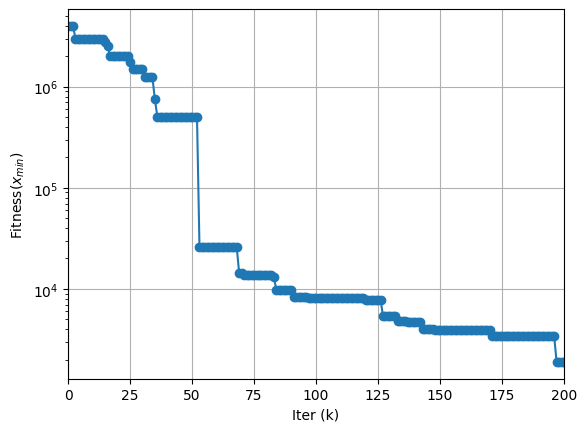

**Figura 3.** Minimização da função $Fitness(x_{min})$.

In [14]:
plt.figure()
plt.plot(fitness_history['iter'],fitness_history['fitness'],'-o')
plt.xlabel('Iter (k)')
plt.ylabel('Fitness($x_{min}$)')
plt.xlim([0,200])
plt.yscale("log")

plt.grid()
plt.show()
display(Markdown("**Figura 3.** Minimização da função $Fitness(x_{min})$."))

In [15]:
display(Markdown('**O vetor solução é:**'))
print(dss_random.bin2dec(fitness_history['xmin'][Niter-1]))
fitness_history['fitness'][Niter-1]

**O vetor solução é:**

[4, 5, 3, 4, 2, 1, 2, 2, 2, 3, 2, 5, 4, 2, 1, 4, 4, 2, 2, 2, 1, 1, 5, 1, 3, 4, 2, 4, 4, 4, 4, 2, 5, 5, 3, 2, 3]


1892.9416706876032

# Conclusões
Após a aplicação do algoritmo genético na resolução do desafiador problema de realocação otimizada de linhas de distribuição, este estudo forneceu importantes insights para a otimização deste tipo de problema. Embora a tarefa seja complexa e apresente uma tendência de gerar soluções infactíveis, o algoritmo genético implementado demonstrou-se uma excelente ferramenta para explorar essa otimização.

No entanto, é importante ressaltar que é necessário um procedimento de melhoria na função objetivo para aumentar a capacidade do AG de apresentar soluções factíveis e resolver completamente esse problema. Portanto, acredita-se que este estudo possa ser utilizado como base para o desenvolvimento de futuros algoritmos que possam aprimorar ainda mais o desempenho do AG na otimização da realocação otimizada de linhas de distribuição.